In [9]:
%pylab inline
import scipy.linalg
import sklearn.metrics as metrics
from sklearn.cross_validation import train_test_split
from numba import jit
import csv
import editdistance
import math

from theano import function, config, shared, sandbox
import theano.tensor as T
from theano.tensor.nnet import conv2d
from theano.tensor.signal.pool import pool_2d

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATAPATH = '/data/vaishaal/endive-exp/EGR1_withNegatives/'

In [16]:
ATCG_MAP = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
ATCG_REV_MAP = ['A', 'T', 'C', 'G']
ATCG = np.eye(4)

def convertSeqToMatrix(XSeq):
    X = np.zeros((len(XSeq), 4*len(XSeq[0])))
    for i,seq in enumerate(XSeq):
        x = np.zeros(4*100)
        X[i] = np.concatenate(map(lambda x: ATCG[ATCG_MAP[x]], seq))
    return X
        
        
def loadSeqFromText(seqFile, delim='\t'):
    XSeq = [] 
    labels = []
    with open(seqFile) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=delim)
        for row in reader:
            seq = row['seq']
            label = row['Bound']
            XSeq.append(seq)
            labels.append(label)
    return XSeq[1:], np.array(labels[1:]).astype('uint8')

            
def loadFoldFromText(foldId):
    npzFile = foldId + ".npz"
    XTrainFile = foldId + "_Train.csv"
    XTestFile = foldId + "_Test.csv"
    yTrainFile = foldId + "_TrainLabels.csv"
    yTestFile = foldId + "_TestLabels.csv"
    return loadFromText(XTrainFile, XTestFile, yTrainFile, yTestFile)


def loadFromText(XTrainFile, XTestFile, yTrainFile, yTestFile):
    with open(XTrainFile) as XFile:
        print("Loading XTrain... from " + XTrainFile)
        XTrainRaw = np.loadtxt(XFile, dtype="uint8", delimiter=",")
    
    with open(XTestFile) as XFile:
        print("Loading XTest... from " + XTestFile)
        XTestRaw = np.loadtxt(XFile, dtype="uint8", delimiter=",")
     
    with open(yTrainFile) as yFile:
        print("Loading yTrain... from " + yTrainFile)
        yTrainRaw = np.loadtxt(yFile, dtype="uint8", delimiter=",")
    with open(yTestFile) as yFile:
        print("Loading yTest.. from " + yTestFile)
        yTestRaw = np.loadtxt(yFile, dtype="uint8", delimiter=",")
    return (XTrainRaw, XTestRaw, yTrainRaw, yTestRaw)
        
def loadFromNpz(npzFile):
    npz = np.load(npzFile)
    XTrainRaw = npz["XTrain"]
    XTestRaw = npz["XTest"]
    yTrainRaw = npz["yTrain"]
    yTestRaw = npz["yTest"]
    return XTrainRaw, XTestRaw, yTrainRaw, yTestRaw

    
def saveToNpz(fname, XTrain, XTest, yTrain, yTest):
    f = open(fname, "w+")
    numpy.savez(f, XTrain=XTrain, XTest=XTest, yTrain=yTrain, yTest=yTest)
    f.close()
    return 0
        
def evaluateDualModel(kMatrix, model, TOT_FEAT=1):
    kMatrix *= TOT_FEAT
    y = kMatrix.dot(model)
    kMatrix /= TOT_FEAT
    return y[:, 1] 
            
    
def learnPrimal(trainData, labels, W=None, reg=0.1):
    '''Learn a model from trainData -> labels '''

    trainData = trainData.reshape(trainData.shape[0],-1)
    n = trainData.shape[0]
    X = np.ascontiguousarray(trainData, dtype=np.float32).reshape(trainData.shape[0], -1)
    if (W == None):
        W = np.ones(n)[:, np.newaxis]

    print "X SHAPE ", trainData.shape
    print "Computing XTX"
    sqrtW = np.sqrt(W)
    X *= sqrtW
    XTWX = X.T.dot(X)
    print "Done Computing XTX"
    idxes = np.diag_indices(XTWX.shape[0])
    XTWX[idxes] += reg
    y = np.eye(max(labels) + 1)[labels]
    XTWy = X.T.dot(W * y)
    model = scipy.linalg.solve(XTWX, XTWy)
    return model

def trainAndEvaluateDualModel(KTrain, KTest, labelsTrain, labelsTest, reg=0.1):
    model = learnDual(KTrain,labelsTrain, reg=reg)
    predTrainWeights = evaluateDualModel(KTrain, model)
    predTestWeights = evaluateDualModel(KTest, model)
    train_roc = metrics.roc_curve(labelsTrain, predTrainWeights)
    test_roc = metrics.roc_curve(labelsTest, predTestWeights)
    return (train_roc, test_roc)

def learnDual(gramMatrix, labels, reg=0.1, TOT_FEAT=1, NUM_TRAIN=1):
    ''' Learn a model from K matrix -> labels '''
    print ("Learning Dual Model")
    y = np.eye(max(labels) + 1)[labels]
    idxes = np.diag_indices(gramMatrix.shape[0])
    gramMatrix /= float(TOT_FEAT)
    print "reg is " + str(reg)
    gramMatrix[idxes] += (reg)
    model = scipy.linalg.solve(gramMatrix, y)
    gramMatrix[idxes] -= (reg)                                                                   
    gramMatrix *= TOT_FEAT
    return model

def computeDistanceMatrix(XTest, XTrain):
    XTrain = XTrain.reshape(XTrain.shape[0], -1)
    XTest = XTest.reshape(XTest.shape[0], -1)
    XTrain_norms = (np.linalg.norm(XTrain, axis=1) ** 2)[:, np.newaxis]
    XTest_norms = (np.linalg.norm(XTest, axis=1) ** 2)[:, np.newaxis]
    K = XTest.dot(XTrain.T)
    K *= -2
    K += XTrain_norms.T
    K += XTest_norms  
    return K



def computeRBFGramMatrix(XTest, XTrain, gamma=1):
    gamma = -1.0 * gamma
    print "Gamma is "+  str(gamma)
    return np.exp(gamma*computeDistanceMatrix(XTest, XTrain))

def trainAndEvaluatePrimalModel(XTrain, XTest, labelsTrain, labelsTest, reg=0.0, W=None):
    model = learnPrimal(XTrain, labelsTrain, reg=reg, W=W)
    yTrainHat = XTrain.dot(model)[:,1]
    yTestHat = XTest.dot(model)[:,1]
    
    yTrainPred = np.argmax(XTrain.dot(model), axis=1)
    yTestPred = np.argmax(XTest.dot(model), axis=1)
    
    print "Train acc", metrics.accuracy_score(yTrainPred, labelsTrain)
    print "Test acc", metrics.accuracy_score(yTestPred, labelsTest)
    train_roc = metrics.roc_curve(labelsTrain, yTrainHat)
    test_roc = metrics.roc_curve(labelsTest, yTestHat)
    return (train_roc, test_roc)

@jit(nopython=True)
def generateNgrams(x, n, alpha_size=4):
    outsize = int(x.shape[0]/alpha_size - n + 1)
    ngrams = np.zeros((outsize, n*alpha_size))
    for i in range(outsize):
        ngrams[i] = x[i*alpha_size:(i+n)*alpha_size]
    return ngrams

@jit(nopython=True)
def fast_cos(X):
    flat_x = X.ravel()
    for i in range(len(flat_x)):
        flat_x[i] = math.cos(flat_x[i])
    return X
    

def generateConvFeatures(X, W, offset=None,  gpu=False, alpha_size=4):
    n = W.shape[-1]/4 
    if (gpu):
        conv_out = convTheano(X,W)
    else:
        conv_out = convCPU(X,W)

    # Pool 
    pool_out = np.sum(conv_out, axis=1)

    return pool_out.reshape(pool_out.shape[0], pool_out.shape[-1])

    
    

def convCPU(X, W, offset, alpha_size=4):
    conv_out_shape = (X.shape[-1] - W.shape[-1])/4 + 1 
    X_lift = np.zeros((X.shape[0], conv_out_shape, W.shape[0]))
    scale = np.sqrt(2/float(W.shape[0])) 
    for i in range(X.shape[0]):
        if (i % 1000 == 0):
            print i, "Images Convolved"
        ngrams = generateNgrams(X[i,:], W.shape[-1]/4, alpha_size)
        xlift_conv = np.cos(np.dot(ngrams, W.T) + offset)
        X_lift[i] = xlift_conv
    return X_lift

def convTheano(X, W, batch_size=4096, offset=0, alpha_size=4):
    X = X.reshape(X.shape[0], 1, 1, X.shape[1])
    W = W.reshape(W.shape[0], 1, 1, W.shape[1])
    d = W.shape[-1]
    D = W.shape[0]
    offsetTheano = shared(offset)
    conv_out_shape = (X.shape[-1] - W.shape[-1])/alpha_size + 1 
    print conv_out_shape
    print W.shape[0]
    print W.ravel()[0]
    XOut = np.zeros((X.shape[0], conv_out_shape, W.shape[0]))
    num_batches = int(np.ceil(X.shape[0]/batch_size))
    WTheano = shared(W)
    for b in range(num_batches):
        print "Data Batch ", b
        end = min((b+1)*batch_size, X.shape[0])
        start = b*batch_size
        size = end - start
        XBatch = X[start:end]
        XBatchTheano = shared(XBatch)
        conv_out = conv2d(XBatchTheano, WTheano, subsample=(1, 4), filter_flip=False).eval().reshape(size, D, conv_out_shape)
        XOut[start:end, :, :] = conv_out.transpose(0,2,1)
    return XOut


def computeConvNorm(x,n,alpha_size=4):
    ngrams = generateNgrams(x, n)
    for k in range(ngrams.shape[0]):
        ngram1 = ngrams[int(k),:]
        for l in range(ngrams.shape[0]):
            ngram2 = ngrams[int(l), :]
            k += np.dot(ngram1, ngram2)/(np.linalg.norm(ngram1)*np.linalg.norm(ngram2))
    return np.sqrt(k)


def generateAllNgrams(X, n,alpha_size=4):
    outsize = X.shape[1]/alpha_size - n + 1
    ngramMat = np.zeros((X.shape[0], outsize, n*alpha_size))
    for i in range(X.shape[0]):
        ngramMat[i] = generateNgrams(X[i,:], n)
    return ngramMat
    
def alphaVectorToString(alphavector, alpha_size=4):
    return ATCG_REV_MAP[np.argmax(alphavector)]
    
def vectorToString(vector, alpha_size=4):
    out = ''
    for i in range(vector.shape[0]/alpha_size):
        out += alphaVectorToString(vector[i*alpha_size:(i+1)*alpha_size])
    return out
        
def computeConvKernelValue(x,y,n,alpha_size=4):
    normX = computeConvNorm(x,n)
    normY = computeConvNorm(y,n)
    print 'normX', normX
    print 'normY', normY
    ngramsX = generateNgrams(x, n)
    ngramsY = generateNgrams(y, n)
    for k in range(ngramsX.shape[0]):
        ngram1 = ngramsX[int(k),:]
        for l in range(ngramsY.shape[0]):
            ngram2 = ngramsY[int(l), :]
            k += np.dot(ngram1, ngram2)/(np.linalg.norm(ngram1)*np.linalg.norm(ngram2))
    return k/(float(normX)*float(normY))
    
    
@jit(nopython=True)
def computeConvKernel(XTrain,XTest,n,alpha_size=4,gamma=0.01):
    K = np.zeros((XTest.shape[0], XTrain.shape[0]))
    outsize = XTrain.shape[1]/alpha_size - n + 1 
    for i in range(XTrain.shape[0]):
        for j in range(XTest.shape[0]):
            train = generateNgrams(XTrain[int(i),:], n)
            test = generateNgrams(XTest[int(j),:], n)
            for k in range(train.shape[0]):
                ngram1 = train[int(k),:]
                for l in range(test.shape[0]):
                    ngram2 = test[int(l),:]
                    diff = (ngram1 - ngram2)
                    K[j,i] += np.exp(-gamma*np.sum(diff * diff))
    return K
                  
@jit(nopython=True)
def computeNgramKernel(XTrain,XTest,n,alpha_size=4,gamma=0.01):
    K = np.zeros((XTest.shape[0], XTrain.shape[0]))
    outsize = XTrain.shape[1]/alpha_size - n + 1 
    for i in range(XTrain.shape[0]):
        for j in range(XTest.shape[0]):
            train = generateNgrams(XTrain[int(i),:], n)
            test = generateNgrams(XTest[int(j),:], n)
            for k in range(train.shape[0]):
                ngram1 = train[int(k),:]
                for l in range(test.shape[0]):
                    ngram2 = test[int(l),:]
                    K[j,i] += int(np.all(ngram1 == ngram2))
            
    return K
                
                    
           
            
        
    

In [11]:
XSeqTrain, labelsTrain = loadSeqFromText(DATAPATH + "EGR1_GM12878_Egr-1_HudsonAlpha_AC.seq", delim=' ')

In [12]:
XSeqTest, labelsTest = loadSeqFromText(DATAPATH + "EGR1_GM12878_Egr-1_HudsonAlpha_B.seq", delim='\t')

In [13]:
XTrain = convertSeqToMatrix(XSeqTrain)
XTest = convertSeqToMatrix(XSeqTest)

In [7]:
D =4096
W = np.random.randn(D,8*4) * 1
b = np.random.uniform(0,1,size=D)


In [ ]:
%time XLiftTrain_cpu = generateConvFeatures(XTrain, W, offset=b, gpu=False)
%time XLiftTest_cpu = generateConvFeatures(XTest, W, offset=b, gpu=False)

0 Images Convolved
1000 Images Convolved
2000 Images Convolved
3000 Images Convolved
4000 Images Convolved
5000 Images Convolved
6000 Images Convolved
7000 Images Convolved
8000 Images Convolved
9000 Images Convolved
10000 Images Convolved
11000 Images Convolved
12000 Images Convolved
13000 Images Convolved
14000 Images Convolved
15000 Images Convolved
16000 Images Convolved
17000 Images Convolved
18000 Images Convolved
19000 Images Convolved
20000 Images Convolved
21000 Images Convolved
22000 Images Convolved
23000 Images Convolved
24000 Images Convolved
25000 Images Convolved
26000 Images Convolved
27000 Images Convolved
28000 Images Convolved
29000 Images Convolved
30000 Images Convolved
31000 Images Convolved
Doing Element wise cosine


X SHAPE  (31662, 404)
Computing XTX
Done Computing XTX
Train acc 0.6021097846
Test acc 0.644644644645
Train ROC  0.638565364954
Test ROC  0.721314629259


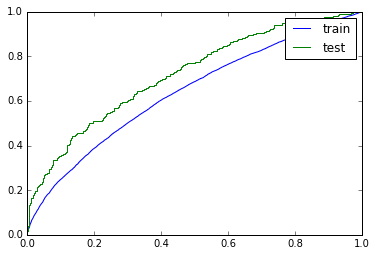

In [11]:
train_roc, test_roc = trainAndEvaluatePrimalModel(XTrain, XTest, labelsTrain, labelsTest)
train = plt.plot(train_roc[0], train_roc[1], label="train")
test = plt.plot(test_roc[0], test_roc[1], label="test")
print "Train ROC ", metrics.auc(train_roc[0], train_roc[1])
print "Test ROC ", metrics.auc(test_roc[0], test_roc[1])
plt.legend(handles=[train[0], test[0]])

X SHAPE  (31662, 1024)
Computing XTX
Done Computing XTX
Train acc 0.774524666793
Test acc 0.499499499499
Train ROC  0.866984550801
Test ROC  0.5


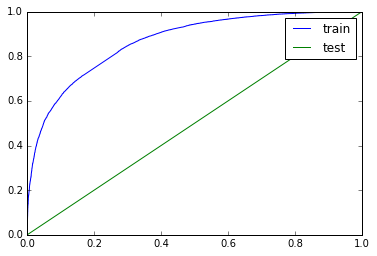

In [16]:
train_roc, test_roc = trainAndEvaluatePrimalModel(XLiftTrain_cpu, XLiftTest_cpu,labelsTrain,labelsTest)
train = plt.plot(train_roc[0], train_roc[1], label="train")
test = plt.plot(test_roc[0], test_roc[1], label="test")
print "Train ROC ", metrics.auc(train_roc[0], train_roc[1])
print "Test ROC ", metrics.auc(test_roc[0], test_roc[1])
plt.legend(handles=[train[0], test[0]])

X SHAPE  (31662, 1024)
Computing XTX
Done Computing XTX
Train acc 0.519265997094
Test acc 0.545545545546
Train ROC  0.529912695391
Test ROC  0.560785571142


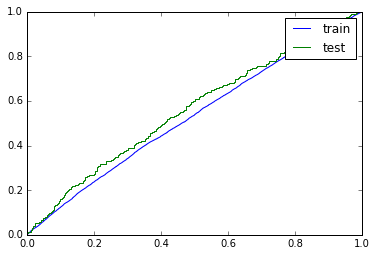

In [58]:
train_roc, test_roc = trainAndEvaluatePrimalModel(XTrainLift, XTestLift,labelsTrain,labelsTest)
train = plt.plot(train_roc[0], train_roc[1], label="train")
test = plt.plot(test_roc[0], test_roc[1], label="test")
print "Train ROC ", metrics.auc(train_roc[0], train_roc[1])
print "Test ROC ", metrics.auc(test_roc[0], test_roc[1])
plt.legend(handles=[train[0], test[0]])

In [ ]:
KGram = computeRBFGramMatrix(XTrain[:10,:], XTrain[:10, :], 100)
print KGram

In [181]:
W = np.random.randn(8192*8,101*4) * 100
b = np.random.uniform(32)
Xlift = np.sqrt(2.0/(8192*8)) * np.cos(XTrain[:10].dot(W.T) + b)
print np.round(Xlift.dot(Xlift.T))

[[ 1.  0.  0. -0. -0.  0.  0. -0.  0.  0.]
 [ 0.  1.  0.  0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0. -0.  0. -0. -0.]
 [-0.  0.  0.  1.  0.  0. -0. -0. -0. -0.]
 [-0.  0.  0.  0.  1.  0. -0.  0.  0. -0.]
 [ 0. -0.  0.  0.  0.  1. -0. -0.  0. -0.]
 [ 0.  0. -0. -0. -0. -0.  1. -0.  0. -0.]
 [-0.  0.  0. -0.  0. -0. -0.  1.  0.  0.]
 [ 0.  0. -0. -0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0. -0. -0. -0. -0. -0.  0.  0.  1.]]


Learning Dual Model
reg is 0.1
Train ROC  1.0
Test ROC  0.5


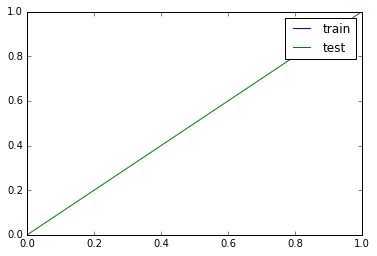

In [199]:
train_roc, test_roc = trainAndEvaluateDualModel(KTrain, KTest, yTrain, yTest)
train = plt.plot(train_roc[0], train_roc[1], label="train")
test = plt.plot(test_roc[0], test_roc[1], label="test")
print "Train ROC ", metrics.auc(train_roc[0], train_roc[1])
print "Test ROC ", metrics.auc(test_roc[0], test_roc[1])
plt.legend(handles=[train[0], test[0]])

In [184]:
yTest.shape

(999,)